<a href="https://colab.research.google.com/github/Angus-Eastell/Intro_to_AI/blob/main/3_linear_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Linear Classification

For the first few questions, we're going to work with the following dataset.

Our goal will be to use the two features, $x_1$ and $x_2$, to classify the points: class 0 is purple, class 1 is yellow.

Text(0, 0.5, '$x_2$')

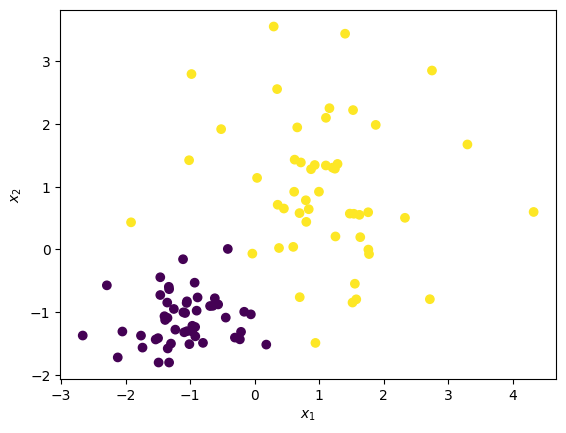

In [1]:
import torch as t
import matplotlib.pyplot as plt
t.manual_seed(1) #Fix the random seed, so we always generate the same data.

N = 100
x_class_0 = 0.5*t.randn(N//2, 2) - 1
x_class_1 = t.randn(N//2, 2) + 1
X = t.cat([x_class_0, x_class_1], 0)
y = t.cat([t.zeros(N//2, 1), t.ones(N//2, 1)], 0)

plt.scatter(x=X[:, 0], y=X[:, 1], c=y)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

## 1) Numerical stability in computing the loss

First, we're going to compute the loss (i.e. minus the log-probability),
\begin{align}
  \mathcal{L} = -\sum_{i=1}^N (y_i \log \sigma(\mathbf{x}_i \mathbf{w}) + (1-y_i) \log \sigma(-\mathbf{x}_i \mathbf{w}))
\end{align}

#### 1.1) Compute the loss using the sigmoid
Write a function that takes a value for the weights as input, and returns the objective.  Use the most obvious approach, i.e. `t.sigmoid`.


In [15]:
#Your code here
def neg_loss(w):
  loss = - t.sum( (y * t.log( t.sigmoid(X @ w))) + (1 -y) * t.log( t.sigmoid( (- X @ w))) )
  return loss


In [9]:
# @title Answer

def loss_sigmoid(w):
    l = X@w
    return -(y*t.log(t.sigmoid(l)) + (1-y)*t.log(t.sigmoid(-l))).sum()

#### 1.2 Numerical instability in the naive loss.

The problem is that this form is numerically unstable.  Try
\begin{align}
\mathbf{w} = \begin{pmatrix} 20 \\ 20 \end{pmatrix}
\end{align}
You should get a NaN!

In [17]:
#Your code here
w = 20*t.ones(2,1)

neg_loss(w)



tensor(nan)

In [10]:
# @title Answer

w = 20*t.ones(2,1)
loss_sigmoid(w)

tensor(nan)

#### 1.3) log-sigmoid should be numerically stable.

The numerical instability should be fixable.  Plot
\begin{align}
 p = \log \sigma(\ell)
\end{align}
For $\ell$ between -100 and 100.

The plot should look very reasonable.  But note that the lower y's are `-inf`!

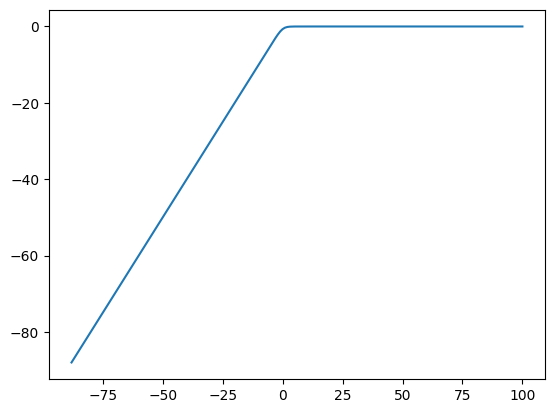

In [21]:
#Your code here

l = t.arange(-100, 101)
p = t.log( t.sigmoid(l))

plt.plot(l,p)

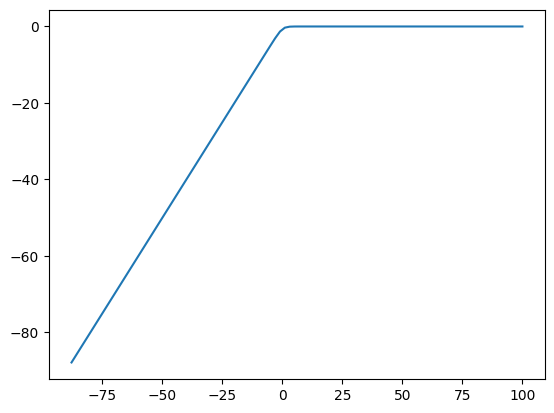

In [29]:
# @title Answer

l = t.linspace(-100, 100, 100)
plt.plot(l, t.log(t.sigmoid(l)))

#### 1.4) Diagnose the problem

Work out why $\log \sigma(\ell)$ is having numerical issues for values of $x$ about -100.

In [37]:
#Your code here

l = t.tensor(-30)
print(t.sigmoid(l))
p = t.log(t.sigmoid(l))
print(p)

# the issues arises as when l decreases to closer to -100 t.sigmoid(l) is close to 0.
# At this point compuationally t.sigmoid(l) = 0 and you cannot take a natrual log of 0
# therefore the log function retruns - inf


tensor(9.3576e-14)
tensor(-30.)


In [ ]:
# @title Answer

#The problem is that t.sigmoid(-100) is very close to zero.  In fact, its so
#close to zero that at some point, it numerically  underflows and becomes exactly zero,
print(t.sigmoid(t.tensor(-50)))
print(t.sigmoid(t.tensor(-100)))
#And log 0. is -inf
print(t.log(t.tensor(0.)))

tensor(1.9287e-22)
tensor(0.)
tensor(-inf)


#### 1.5 Use the numerically stable logsigmoid function

PyTorch implements a numerically stable `logsigmoid` function ([docs](https://pytorch.org/docs/stable/generated/torch.nn.functional.logsigmoid.html)).  Check that `logsigmoid` is indeed numerically stable.  Then implement the loss in terms of `logsigmoid`, and check that this loss is also numerically stable, specifically, that the loss works with,
\begin{align}
\mathbf{w} = \begin{pmatrix} 20 \\ 20 \end{pmatrix}
\end{align}

In [50]:
#Your code here
def log_sig(w):

  loss = t.sum( y * t.nn.functional.logsigmoid(X @ w) + (1-y)* t.nn.functional.logsigmoid(- X @ w))
  return loss

w = 20 * t.ones(2,1)
# checking if numerically stable
#-100. so floating point
l = t.tensor(-100.)
print(t.nn.functional.logsigmoid(l))

log_sig(w)




tensor(-100.)


tensor(-44.4466)

In [ ]:
# @title Answer

print(t.nn.functional.logsigmoid(t.tensor(-100.)))
print(t.nn.functional.logsigmoid(t.tensor(-1000.)))

def loss(w):
    l = X@w
    return -(y*t.nn.functional.logsigmoid(l) + (1-y)*t.nn.functional.logsigmoid(-l)).sum()

print(loss(20*t.ones(2,1)))

tensor(-100.)
tensor(-1000.)
tensor(44.4466)


## Implementing the gradients and doing gradient descent

We implement the gradients using the expression from the main text,

\begin{align}
  \frac{\partial \mathcal{L}}{\partial w_\nu} = -\sum_{i=1}^N (y_i \log \sigma(-\mathbf{x}_i \mathbf{w}) - (1-y_i) \log \sigma(\mathbf{x}_i \mathbf{w}))
\end{align}

In [ ]:
def grad(w):
    l = X@w
    return - X.mT@(y*t.sigmoid(-l) - (1-y)*t.sigmoid(l))

learning_rate = 0.01
w = t.zeros(2,1)
for i in range(100):
    w = w - learning_rate*grad(w)
    if 0 == i%10:
        print(loss(w))

tensor(31.7334)
tensor(12.6013)
tensor(10.8425)
tensor(10.2113)
tensor(9.9054)
tensor(9.7344)
tensor(9.6302)
tensor(9.5632)
tensor(9.5183)
tensor(9.4873)


Note that not just are the gradient difficult to derive.  They difficult to implement correctly.  I spent far too long getting all the signs in the right place in the expression for the gradients....

Now, we can plot the resulting decision boundary.  Note the code to do the plotting doesn't demonstrate any particulary important concepts and is non-examinable.

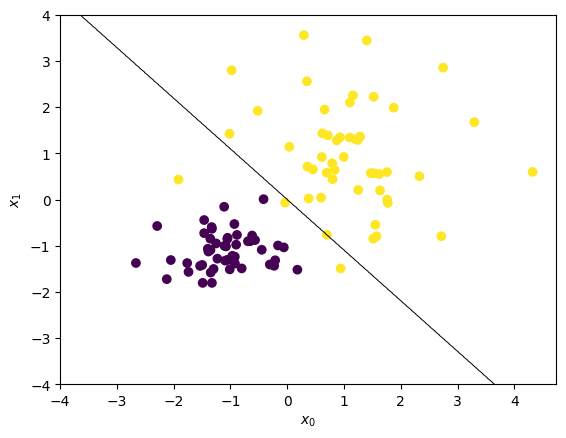

In [ ]:
def plot_decision_boundary(net, X, Y):
    #Non-examinable; just for demonstration purposes.
    x0_grid, x1_grid = t.meshgrid(t.linspace(-4, 4, 1000),
                                  t.linspace(-4, 4, 1000),
                                  indexing="ij")

    X_grid = t.stack([x0_grid, x1_grid], dim=-1)
    c_grid = (0<net(X_grid))[..., 0].detach()

    plt.contour(x0_grid, x1_grid, c_grid, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=Y)

    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

plot_decision_boundary(lambda X: X@w, X, y)